In [2]:
import yfinance as yf 
import pandas as pd
import requests
import io
import os
import time
from datetime import datetime, timezone, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
import pandas_ta as ta



In [184]:
#just reading the html file using pd.read_html is forbidden so
# Ref: https://stackoverflow.com/a/75845569/
def list_slickcharts_sp500() -> pd.DataFrame:
    url = 'https://www.slickcharts.com/sp500'
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/111.0'  # Default user-agent fails.
    response = requests.get(url, headers={'User-Agent': user_agent})
    return pd.read_html(io.StringIO(response.text), match='Symbol', index_col='Symbol')[0]

In [53]:
#idea store df as list append date to it see if date varies by a whole day 
#if so fetch new list if not read_csv
def get_sp500_names(path):
    if os.path.isfile(path):
        modified=modified = datetime.fromtimestamp(os.path.getmtime(path), tz=timezone.utc)
        curr_date=datetime.now(timezone.utc)
        if curr_date-modified>=timedelta(days=180):
            data=list_slickcharts_sp500().reset_index()
            filter_data=data[["Symbol","Company"]]
            filter_data.to_csv(path)
            return filter_data
        else:
            data=pd.read_csv(path)
            return data 
    else:
        data=list_slickcharts_sp500().reset_index()
        filter_data=data[["Symbol","Company"]]
        filter_data.to_csv(path)
        return filter_data

In [52]:
data=list_slickcharts_sp500().reset_index()
print(data.columns)
print("S&P 500 Companies ", data)
print("Missing value ", data.isna().sum())

Index(['Symbol', '#', 'Company', 'Weight', 'Price', 'Chg', '% Chg'], dtype='object')
S&P 500 Companies      Symbol    #                     Company Weight   Price   Chg     % Chg
0     NVDA    1                      Nvidia  7.03%  168.23  1.20   (0.72%)
1     MSFT    2                   Microsoft  6.35%  498.36  3.36   (0.68%)
2     AAPL    3                  Apple Inc.  6.06%  238.23 -1.47  (-0.61%)
3     AMZN    4                      Amazon  4.31%  235.86  3.53   (1.52%)
4     META    5              Meta Platforms  3.24%  751.90 -0.55  (-0.07%)
..     ...  ...                         ...    ...     ...   ...       ...
498    CRL  499  Charles River Laboratories  0.01%  159.60 -4.39  (-2.68%)
499   MKTX  500                 MarketAxess  0.01%  188.60  1.10   (0.59%)
500    NWS  501         News Corp (Class B)  0.01%   33.66  0.26   (0.78%)
501    CZR  502       Caesars Entertainment  0.01%   26.39  0.05   (0.17%)
502   ENPH  503              Enphase Energy  0.01%   38.65 -1.00  (-2.5

In [54]:
tickers_df=get_sp500_names("raw/sp500_tickers.csv")
tickers=list(tickers_df["Symbol"])
print(tickers[:10])
print(len(tickers))

['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK.B']
503


In [55]:
#i also got a list of companies from kaggle
sp500_companies=pd.read_csv("raw/sp500_companies.csv")
sp500_index=pd.read_csv("raw/sp500_index.csv")


In [228]:
#analyse kaggle data to see if we could use any of these for our features
sp500_companies.head()
#rename symbol to ticker
sp500_companies.rename(columns={"Symbol":"Ticker"})
sp500_companies.to_csv("raw/sp500_companies.csv")
#we can see sector, market_cap, revenue_growth, full_time_employees, long_business summaries

In [57]:
sp500_index.head()
#idk what this is

,Date,S&P500
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57


In [9]:
def fix_indexes_yfinance(df):
    return df.stack(level=0, future_stack=True).rename_axis(["Date","Ticker"]).reset_index(level=1)

In [146]:
#get historical data and save it as a csv
def get_sp500_data(path, tickers):
    #check if the path or the csv alr exists
    if os.path.isfile(path):
        #if it exists only modify or append latest rows figure out later
        df=pd.read_csv(path,parse_dates=["Date"])
        df["Date"] = pd.to_datetime(df["Date"]) 
        latest_csv_date=df["Date"].max().date()
        #fetch data from the latest csv to now if theres anything to fetch
        if latest_csv_date!= datetime.today().date():
            start_date=latest_csv_date+timedelta(days=1)
            yf_data_latest=yf.download(tickers,start=start_date, end=datetime.today(), group_by="Ticker")
            yf_data_latest=fix_indexes_yfinance(yf_data_latest).reset_index()
            if not yf_data_latest.empty: 
                yf_data_latest.dropna(inplace=True)
                df = pd.concat([df, yf_data_latest])
                df.to_csv(path, index=False)
        return (pd.read_csv(path))
    else:
        #fetch historical data from
        data=yf.download(tickers, start="2003-01-01", end="2025-09-1", group_by="Ticker")
        #since this comes with multi-level index need to handle that
        # Transform the DataFrame: stack the ticker symbols to create a multi-index (Date, Ticker), then reset the 'Ticker' level to turn it into a column
        df=fix_indexes_yfinance(data).reset_index()
        df.dropna(inplace=True)
        df.to_csv(path, index=False)
        df_csv=pd.read_csv(path)
        return df_csv

In [147]:
data=get_sp500_data("raw/sp500_historical.csv",tickers[:5])

/var/folders/94/xf2q8_bs543d00kh0st2v5t80000gn/T/ipykernel_59006/1047871664.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(tickers, start="2003-01-01", end="2025-09-1", group_by="Ticker")
[*********************100%***********************]  5 of 5 completed


In [157]:
#some useful features spotted here so
sp500_companies.isna().sum()
sp500_companies.dropna(inplace=True)

In [167]:
sp500_companies.rename(columns={"Symbol":"Ticker"}, inplace=True)
sp500_companies.head()

,Exchange,Ticker,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


In [ ]:
df=pd.merge(data,sp500_companies[["Ticker","Sector","Industry"]],
            how="inner", on="Ticker")


In [175]:
print(df.head())
print(df.isna().sum())
print(df.shape)

         Date Ticker       Open       High        Low      Close  \
0  2003-01-02   NVDA   0.091694   0.095132   0.088561   0.094062   
1  2003-01-02   AAPL   0.215545   0.223950   0.215394   0.222149   
2  2003-01-02   AMZN   0.959500   0.984000   0.927500   0.978500   
3  2003-01-02   MSFT  16.003781  16.447481  15.823241  16.438301   
4  2003-01-03   NVDA   0.094368   0.097425   0.092458   0.094062   

         Volume             Sector                   Industry  \
0  1.302540e+09         Technology             Semiconductors   
1  1.814288e+08         Technology       Consumer Electronics   
2  1.296800e+08  Consumer Cyclical            Internet Retail   
3  6.702520e+07         Technology  Software - Infrastructure   
4  1.037496e+09         Technology             Semiconductors   

                                 Longbusinesssummary  
0  NVIDIA Corporation provides graphics and compu...  
1  Apple Inc. designs, manufactures, and markets ...  
2  Amazon.com, Inc. engages in the 

In [178]:
df.to_csv("raw/sp500_historical_extra_features.csv")

In [ ]:
#clean implementation now

In [197]:
#fetch tickers
def fetch_sp_500_tickers():
    data=list_slickcharts_sp500().reset_index()
    tickers=list(data["Symbol"])
    return tickers

def normalize_ticker(ticker):
    return ticker.replace(".", "-")

In [214]:
def fetch_sp_500_data(tickers, start_date="2003-1-1", end_date=datetime.now()):
    data=yf.download([normalize_ticker(t) for t in tickers], 
                     start=start_date, 
                     end=end_date, group_by="Ticker", 
                     auto_adjust=False)
    df=fix_indexes_yfinance(data).reset_index()
    return df

In [234]:
def batch_sp_500_download():
    tickers=fetch_sp_500_tickers()
    total_tickers=len(tickers)
    df=pd.DataFrame()
    all_dfs=[]
    # loop through 20 tickers each
    for i in range(0,total_tickers,10):
        subset_tickers=tickers[i:i+10]
        subset_df=fetch_sp_500_data(subset_tickers)
        all_dfs.append(subset_df)
    final_df = pd.concat(all_dfs, ignore_index=True)
    #since missing values caused by companies not being public or established
    #drop em before returning
    final_df = final_df.dropna(subset=["Open", "High", "Low", "Close", "Volume"], how="all")
    #sort the df

    return final_df
    

In [245]:
df=batch_sp_500_download()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*****

In [246]:
df.shape

(2585957, 8)

In [247]:
df.head()

Price,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
3,2003-01-02,BRK-B,48.400002,48.740002,47.680000,47.880001,47.880001,7.700000e+05
5,2003-01-02,NVDA,0.100000,0.103750,0.096583,0.102583,0.094062,1.302540e+09
6,2003-01-02,MSFT,26.150000,26.875000,25.855000,26.860001,16.438303,6.702520e+07
7,2003-01-02,AAPL,0.256429,0.266429,0.256250,0.264286,0.222149,1.814288e+08
8,2003-01-02,AMZN,0.959500,0.984000,0.927500,0.978500,0.978500,1.296800e+08


In [2]:
# now that we got all our data
def get_df_details(df):
    print("Shape ", df.shape)
    print("Columns ", df.columns)
    print("Missing by columns ", df.isna().sum())
    print("Missing by companies ",df.groupby("Ticker")[["Date","Open","High","Low","Close","Volume"]].apply(lambda x: x.isna().sum()))


In [248]:
#check final shape
get_df_details(df)

Shape  (2585957, 8)
Columns  Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object', name='Price')
Missing by columns  Price
Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing by companies  Price   Date  Open  High  Low  Close  Volume
Ticker                                      
A          0     0     0    0      0       0
AAPL       0     0     0    0      0       0
ABBV       0     0     0    0      0       0
ABNB       0     0     0    0      0       0
ABT        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XYZ        0     0     0    0      0       0
YUM        0     0     0    0      0       0
ZBH        0     0     0    0      0       0
ZBRA       0     0     0    0      0       0
ZTS        0     0     0    0      0       0

[503 rows x 6 columns]


In [249]:
# merge the sp 500 companies csv
df=pd.merge(df,sp500_companies[["Ticker","Sector","Industry"]], on="Ticker", how="left")

In [250]:
get_df_details(df)

Shape  (2585957, 10)
Columns  Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Sector', 'Industry'],
      dtype='object')
Missing by columns  Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Sector       339516
Industry     339516
dtype: int64
Missing by companies          Date  Open  High  Low  Close  Volume
Ticker                                      
A          0     0     0    0      0       0
AAPL       0     0     0    0      0       0
ABBV       0     0     0    0      0       0
ABNB       0     0     0    0      0       0
ABT        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XYZ        0     0     0    0      0       0
YUM        0     0     0    0      0       0
ZBH        0     0     0    0      0       0
ZBRA       0     0     0    0      0       0
ZTS        0     0     0    0      0       

In [253]:
# handle missing (ML Model will handle missing
df['Sector'] = df['Sector'].fillna('Unknown')
df['Industry'] = df['Industry'].fillna('Unknown')

In [257]:
#save this database 
df.to_csv("raw/sp500_historical.csv", index=False)

In [23]:
df=pd.read_csv("raw/sp500_historical.csv")
get_df_details(df)

Shape  (2585957, 11)
Columns  Index(['Unnamed: 0', 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'Sector', 'Industry'],
      dtype='object')
Missing by columns  Unnamed: 0    0
Date          0
Ticker        0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Sector        0
Industry      0
dtype: int64
Missing by companies          Date  Open  High  Low  Close  Volume
Ticker                                      
A          0     0     0    0      0       0
AAPL       0     0     0    0      0       0
ABBV       0     0     0    0      0       0
ABNB       0     0     0    0      0       0
ABT        0     0     0    0      0       0
...      ...   ...   ...  ...    ...     ...
XYZ        0     0     0    0      0       0
YUM        0     0     0    0      0       0
ZBH        0     0     0    0      0       0
ZBRA       0     0     0    0      0       0
ZTS        0     0     0    0      0       0

[503 ro

In [ ]:
#time for feature engineering what features should i add 
#so that my ml model knows whats going on and can make more accurate predictions
def calc_rsi(x, period=14):
    change = x.diff()
    gain = change.where(change > 0, 0.0)
    loss = -change.where(change < 0, 0.0)

    avg_gain = gain.ewm(span=period, min_periods=period).mean()
    avg_loss = loss.ewm(span=period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi



def feature_engineering(df):
    #sort the df before 
    #adj close to get actual returns
    df=df.copy()
    df["Date"]=pd.to_datetime(df["Date"])
    df=df.sort_values(["Ticker","Date"])
    #pct_change x returns at a certain time from the prev x days
    df["return_1d"]=df.groupby("Ticker")["Adj Close"].pct_change(1)
    df["return_5d"]=df.groupby("Ticker")["Adj Close"].pct_change(5)
    df["return_20d"]=df.groupby("Ticker")["Adj Close"].pct_change(20)


    #compute moving averages
    #moving averages help show trend
    df["ma_5d"]=df.groupby("Ticker")["Adj Close"].rolling(5).mean().reset_index(level=0, drop=True)
    df["ma_20d"]=df.groupby("Ticker")["Adj Close"].rolling(20).mean().reset_index(level=0, drop=True)

    #calculate exponential moving averages which puts weight to more recent changes
    #gives your model more to work with
    df["ema_5d"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.ewm(adjust=False, span=5).mean())
    df["ema_20d"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.ewm(adjust=False, span=20).mean())


    #need rolling volatility to see how a stock moves up or down quickly
    #before that we need returns as volatility is needed + its a good feature to have
    #learned that rv for 1 is just the daily change (which makes so much sense)
    df["rv_5d"]=df.groupby("Ticker")["return_1d"].rolling(5).std().reset_index(level=0, drop=True)
    df["rv_20d"]=df.groupby("Ticker")["return_1d"].rolling(20).std().reset_index(level=0,drop=True)

    #since the model might relate days of the week to how well a stock performs add that row as well
    df["week_of_year"]=df["Date"].dt.isocalendar().week
    df["month"]=df["Date"].dt.month
    df["quarter"]=df["Date"].dt.quarter
    df["day_of_month"]=df["Date"].dt.day
    df["is_quarter_start"] = df["Date"].dt.is_quarter_start.astype(int)
    df["is_quarter_end"] = df["Date"].dt.is_quarter_end.astype(int)



    #adding more features as existing features dont show strong correlation
    df["hl_range"]=df["High"]-df["Low"]
    df["vol_change"]=df.groupby("Ticker")["Volume"].pct_change()
    df['oc_diff'] = df['Close'] - df['Open']
    df['gap'] = df['Open'] - df.groupby('Ticker')['Close'].shift(1)

    #momentum indicators
    #rsi is seen as a very useful indicator
    df["rsi"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: calc_rsi(x, 14))
    
    # calculate bollinger band
    b_range=20
    bollinger_ma=df.groupby("Ticker")["Adj Close"].rolling(b_range).mean().reset_index(level=0, drop=True)
    bollinger_std=df.groupby("Ticker")["Adj Close"].rolling(b_range).std().reset_index(level=0,drop=True)
    df["bollinger_upper"]=bollinger_ma+2*bollinger_std
    df["bollinger_lower"]=bollinger_ma-2*bollinger_std

    # Moving Average Convergence Divergence (MACD)
    exp1 = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    exp2 = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df.groupby("Ticker")['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    #target features
    df["target_1d"]=df.groupby("Ticker")["Adj Close"].pct_change(1).shift(-1)
    df["target_5d"]=df.groupby("Ticker")["Adj Close"].pct_change(5).shift(-5)
    df["target_20d"]=df.groupby("Ticker")["Adj Close"].pct_change(20).shift(-20)


    df["bollinger_width"] = (df["bollinger_upper"] - df["bollinger_lower"]) / df["ma_20d"]

    # ATR
    atr_series = df.groupby("Ticker").apply(
        lambda x: ta.atr(high=x["High"], low=x["Low"], close=x["Adj Close"], length=14)
    )
    df["atr_14d"] = atr_series.reset_index(level=0, drop=True)
    df["atr_14d_norm"] = df["atr_14d"] / df["Adj Close"]

    # OBV
    obv_series = df.groupby("Ticker").apply(
        lambda x: ta.obv(close=x["Adj Close"], volume=x["Volume"])
    )
    df["obv"] = obv_series.reset_index(level=0, drop=True)

    # Stochastic Oscillator
    stoch_series = df.groupby("Ticker").apply(
        lambda x: ta.stoch(high=x["High"], low=x["Low"], close=x["Adj Close"], k=14, d=3)
    )
    stoch_series = stoch_series.reset_index(level=0, drop=True)
    df = pd.concat([df, stoch_series], axis=1)

    # ADX
    adx_series = df.groupby("Ticker").apply(
        lambda x: ta.adx(high=x["High"], low=x["Low"], close=x["Adj Close"])
    )
    adx_series = adx_series.reset_index(level=0, drop=True)
    # Drop redundant features
    cols_to_drop = [
        "bollinger_upper","bollinger_lower",
        "sp500_ma_5d","sp500_ma_20d", "sp500_bollinger_upper",
        "sp500_bollinger_lower","sp500_macd"
    ]
    df=df.drop(columns=cols_to_drop)
    df = pd.concat([df, adx_series], axis=1)


    
    df.dropna(inplace=True)
    return df



    

In [5]:
df=pd.read_csv("raw/sp500_historical.csv", index_col=None)

In [25]:
#add features
df=feature_engineering(df)

In [26]:
print(get_df_details(df))

Shape  (2562605, 36)
Columns  Index(['Unnamed: 0', 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'Sector', 'Industry', 'return_1d', 'return_5d',
       'return_20d', 'ma_5d', 'ma_20d', 'ema_5d', 'ema_20d', 'rv_5d', 'rv_20d',
       'day', 'month', 'quarter', 'hl_range', 'vol_change', 'oc_diff', 'gap',
       'rsi', 'bollinger_upper', 'bollinger_lower', 'macd', 'macd_signal',
       'macd_hist', 'target_1d', 'target_5d', 'target_20d'],
      dtype='object')
Missing by columns  Unnamed: 0         0
Date               0
Ticker             0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Sector             0
Industry           0
return_1d          0
return_5d          0
return_20d         0
ma_5d              0
ma_20d             0
ema_5d             0
ema_20d            0
rv_5d              0
rv_20d             0
day                0
month              0
quarter            0
hl

In [4]:
df.to_parquet("raw/sp500_historical_with_features.parquet", index=False)

NameError: name 'df' is not defined

In [4]:
p_df = pd.read_parquet("../data/processed/sp500_historical_with_features.parquet")

In [8]:
#plotting
def plot_corr_matrix(df): 
    numeric_col=p_df.select_dtypes(include=[np.number])
    
    corr_matrix = numeric_col.corr()
    corr_targets = corr_matrix[['target_1d', 'target_5d', 'target_20d']]
    
    plt.figure(figsize=(10,8))
    sns.heatmap(corr_targets, annot=True, cmap='coolwarm')
    plt.show()

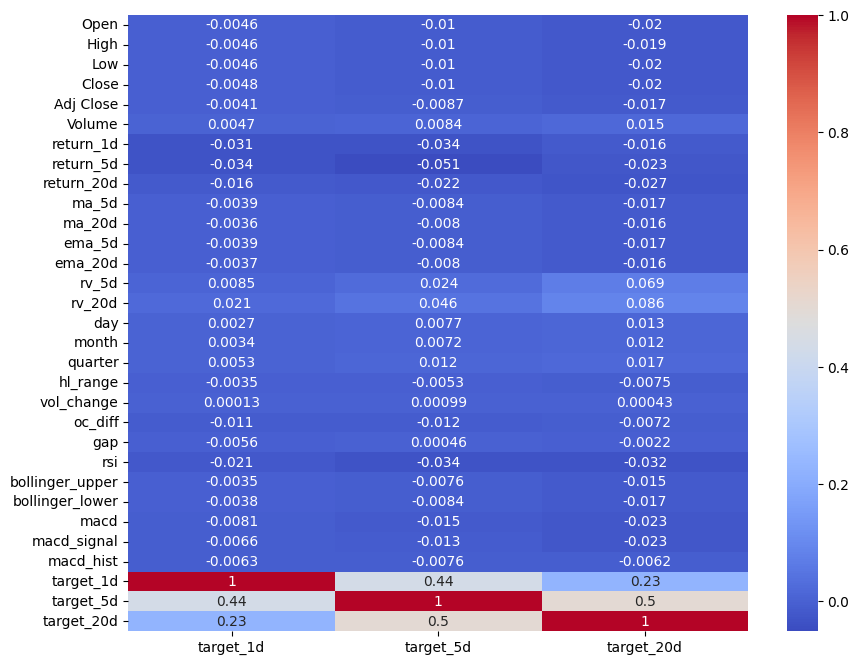

In [9]:
plot_corr_matrix(p_df)

In [11]:
p_df.to_parquet("../data/processed/sp500_historical_with_features.parquet", index=False)

In [26]:
p_df=pd.read_parquet("../data/processed/sp500_historical_with_features.parquet")

In [27]:
p_df.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Sector,Industry,...,macd,macd_signal,macd_hist,target_1d,target_5d,target_20d,day_of_week,day_of_month,is_quarter_start,is_quarter_end
0,2003-01-31,A,11.444921,11.945637,11.316166,11.788269,9.887975,3115303.0,Healthcare,Diagnostics & Research,...,-0.443997,-0.315075,-0.128922,0.000607,-0.305218,-0.209951,4,31,0,0
1,2003-02-03,A,11.788269,12.031474,11.623748,11.795422,9.893975,1972438.0,Healthcare,Diagnostics & Research,...,-0.447477,-0.341556,-0.105922,-0.011522,-0.288660,-0.220740,0,3,0,0
2,2003-02-04,A,11.795422,11.795422,11.273247,11.659514,9.779977,1910227.0,Healthcare,Diagnostics & Research,...,-0.454198,-0.364084,-0.090114,0.001227,-0.260736,-0.200613,1,4,0,0
3,2003-02-05,A,11.659514,12.031474,11.516452,11.673820,9.791975,3479622.0,Healthcare,Diagnostics & Research,...,-0.453331,-0.381934,-0.071397,-0.248774,-0.238358,-0.199755,2,5,0,0
4,2003-02-06,A,11.673820,11.673820,8.769671,8.769671,7.355983,22626071.0,Healthcare,Diagnostics & Research,...,-0.641809,-0.433909,-0.207901,-0.066069,0.015497,0.092169,3,6,0,0


In [15]:
num_col=p_df.select_dtypes(include=[np.number])
print(num_col)

               Open        High         Low       Close   Adj Close  \
0         11.444921   11.945637   11.316166   11.788269    9.887975   
1         11.788269   12.031474   11.623748   11.795422    9.893975   
2         11.795422   11.795422   11.273247   11.659514    9.779977   
3         11.659514   12.031474   11.516452   11.673820    9.791975   
4         11.673820   11.673820    8.769671    8.769671    7.355983   
...             ...         ...         ...         ...         ...   
2562600  151.250000  152.589996  148.759995  151.809998  151.809998   
2562601  160.050003  160.050003  144.509995  146.119995  146.119995   
2562602  146.199997  147.300003  144.250000  146.500000  146.500000   
2562603  147.500000  149.000000  146.899994  148.240005  148.240005   
2562604  148.350006  149.000000  146.270004  147.350006  147.350006   

             Volume  return_1d  return_5d  return_20d       ma_5d  ...  \
0         3115303.0   0.021066  -0.013174   -0.138976    9.922774  ...   

In [ ]:
p_df["vol_change"]=p_df["vol_change"].replace([np.inf, -np.inf], np.nan)
p_df["vol_change"]=p_df["vol_change"].fillna(0)
p_df.isna().sum()

In [34]:
p_df.to_parquet("../data/processed/sp500_historical_with_features.parquet", index=False)

In [75]:
#add sp500 trends to see if overall market trends have a strong correlation with future returns which it almost def does
#add a few other volume features 
#https://finance.yahoo.com/quote/%5ESPX/history/?period1=1041379200&period2=1757864163
#engineer more features that have a better correlation

sp500_overall=yf.download("^GSPC", start="2003-01-01", end=datetime.now(), auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [76]:
sp500_overall.shape

(5711, 6)

In [16]:
sp500_overall.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2025-09-08,6495.149902,6495.149902,6508.669922,6483.290039,6498.089844,5211500000
2025-09-09,6512.609863,6512.609863,6518.229980,6483.080078,6503.330078,4798350000
2025-09-10,6532.040039,6532.040039,6555.970215,6516.339844,6550.290039,5253010000
2025-09-11,6587.470215,6587.470215,6592.890137,6545.799805,6554.410156,5426460000
2025-09-12,6584.290039,6584.290039,6600.209961,6579.490234,6590.660156,4641640000


In [77]:
sp500_overall.columns

MultiIndex([('Adj Close', '^GSPC'),
            (    'Close', '^GSPC'),
            (     'High', '^GSPC'),
            (      'Low', '^GSPC'),
            (     'Open', '^GSPC'),
            (   'Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [78]:
sp500_overall_flattened=sp500_overall.copy(deep=True)

In [37]:
sp500_overall_flattened.columns

MultiIndex([('Adj Close', '^GSPC'),
            (    'Close', '^GSPC'),
            (     'High', '^GSPC'),
            (      'Low', '^GSPC'),
            (     'Open', '^GSPC'),
            (   'Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [ ]:
sp500_overall_flattened.columns.get_level_values("Ticker")
new_df=sp500_overall_flattened.droplevel("Ticker",axis=1)
new_df.reset_index()
new_df.columns.name=(None)
new_df=new_df.reset_index()

Index(['^GSPC', '^GSPC', '^GSPC', '^GSPC', '^GSPC', '^GSPC'], dtype='object', name='Ticker')

In [85]:
new_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2003-01-02,909.030029,909.030029,909.030029,879.820007,879.820007,1229200000
1,2003-01-03,908.590027,908.590027,911.250000,903.070007,909.030029,1130800000
2,2003-01-06,929.010010,929.010010,931.770020,908.590027,908.590027,1435900000
3,2003-01-07,922.929993,922.929993,930.809998,919.929993,929.010010,1545200000
4,2003-01-08,909.929993,909.929993,922.929993,908.320007,922.929993,1467600000


In [ ]:
cols=new_df.columns.tolist()
for i in range(1,len(cols)):
    cols[i]="sp500_"+cols[i]
new_df.columns=cols
new_df.rename(columns={"SP500_Date":"Date"})

In [90]:
new_df.head()

,Date,sp500_Adj Close,sp500_Close,sp500_High,sp500_Low,sp500_Open,sp500_Volume
0,2003-01-02,909.030029,909.030029,909.030029,879.820007,879.820007,1229200000
1,2003-01-03,908.590027,908.590027,911.250000,903.070007,909.030029,1130800000
2,2003-01-06,929.010010,929.010010,931.770020,908.590027,908.590027,1435900000
3,2003-01-07,922.929993,922.929993,930.809998,919.929993,929.010010,1545200000
4,2003-01-08,909.929993,909.929993,922.929993,908.320007,922.929993,1467600000


In [91]:
new_df.to_parquet("../data/raw/sp500_overall.parquet", index=False)

In [74]:
new_df.head()

,sp500_date,sp500_adj close,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume
0,2003-01-02,909.030029,909.030029,909.030029,879.820007,879.820007,1229200000
1,2003-01-03,908.590027,908.590027,911.250000,903.070007,909.030029,1130800000
2,2003-01-06,929.010010,929.010010,931.770020,908.590027,908.590027,1435900000
3,2003-01-07,922.929993,922.929993,930.809998,919.929993,929.010010,1545200000
4,2003-01-08,909.929993,909.929993,922.929993,908.320007,922.929993,1467600000


In [ ]:
#feature engineering on new overall sp500 trends to see if they can help forcasting which they can
def features_sp500_overall(df):
    #will be similar to the sp500 indiv stocks for the most part plus i might add sth more 
    df=df.copy()
    df["Date"]=pd.to_datetime(df["Date"])
    df=df.sort_values(["Date"])
    #pct_change x returns at a certain time from the prev x days
    df["sp500_return_1d"] = df["sp500_Adj Close"].pct_change(1)
    df["sp500_return_5d"]=df["sp500_Adj Close"].pct_change(5)
    df["sp500_return_10d"]=df["sp500_Adj Close"].pct_change(10)
    df["sp500_return_20d"]=df["sp500_Adj Close"].pct_change(20)


    #compute moving averages
    #moving averages help show trend
    df["sp500_ma_5d"]=df["sp500_Adj Close"].rolling(5).mean()
    df["sp500_ma_10d"]=df["sp500_Adj Close"].rolling(10).mean()
    df["sp500_ma_20d"]=df["sp500_Adj Close"].rolling(20).mean()

    #calculate exponential moving averages which puts weight to more recent changes
    #gives your model more to work with
    df["sp500_ema_5d"] = df["sp500_Adj Close"].ewm(adjust=False, span=5).mean()
    df["sp500_ema_10d"] = df["sp500_Adj Close"].ewm(adjust=False, span=10).mean()
    df["sp500_ema_20d"] = df["sp500_Adj Close"].ewm(adjust=False, span=20).mean()


    #need rolling volatility to see how a stock moves up or down quickly
    #before that we need returns as volatility is needed + its a good feature to have
    #learned that rv for 1 is just the daily change (which makes so much sense)
    df["sp500_rv_5d"]=df["sp500_return_1d"].rolling(5).std()
    df["sp500_rv_10d"]=df["sp500_return_1d"].rolling(10).std()
    df["sp500_rv_20d"]=df["sp500_return_1d"].rolling(20).std()

    #adding more features as existing features dont show strong correlation
    df["sp500_hl_range"]=df["sp500_High"]-df["sp500_Low"]
    df["sp500_vol_change"]=df["sp500_Volume"].pct_change()
    df['sp500_oc_diff'] = df['sp500_Close'] - df['sp500_Open']
    df['sp500_gap'] = df['sp500_Open'] - df['sp500_Close'].shift(1)

    #momentum indicators
    #rsi is seen as a very useful indicator
    df["sp500_rsi"] = calc_rsi(df["sp500_Adj Close"], 14)
    
    # calculate bollinger band
    b_range=20
    bollinger_ma=df["sp500_Adj Close"].rolling(b_range).mean()
    bollinger_std=df["sp500_Adj Close"].rolling(b_range).std()
    df["sp500_bollinger_upper"]=bollinger_ma+2*bollinger_std
    df["sp500_bollinger_lower"]=bollinger_ma-2*bollinger_std

    # Moving Average Convergence Divergence (MACD)
    exp1 = df["sp500_Adj Close"].ewm(span=12, adjust=False).mean()
    exp2 = df["sp500_Adj Close"].ewm(span=26, adjust=False).mean()
    df['sp500_macd'] = exp1 - exp2
    df['sp500_macd_signal'] = df['sp500_macd'].ewm(span=9, adjust=False).mean()
    df['sp500_macd_hist'] = df['sp500_macd'] - df['sp500_macd_signal']

    df["sp500_atr_14d"] = ta.atr(
    high=df["sp500_High"], 
    low=df["sp500_Low"], 
    close=df["sp500_Adj Close"], 
    length=14
)

    df["sp500_atr_14d_norm"] = df["sp500_atr_14d"] / df["sp500_Adj Close"]
    df["sp500_obv"]=ta.obv(close=df["sp500_Adj Close"],volume=df["sp500_Volume"])

    df=df.ffill()
    df=df.drop(columns=["sp500_return_1d"])
    df.dropna(inplace=True)
    return df  

In [103]:
feature_engineered_df=features_sp500_overall(new_df)

In [104]:
feature_engineered_df.head()

,Date,sp500_Adj Close,sp500_Close,sp500_High,sp500_Low,sp500_Open,sp500_Volume,sp500_return_5d,sp500_return_10d,sp500_return_20d,...,sp500_hl_range,sp500_vol_change,sp500_oc_diff,sp500_gap,sp500_rsi,sp500_bollinger_upper,sp500_bollinger_lower,sp500_macd,sp500_macd_signal,sp500_macd_hist
20,2003-01-31,855.700012,855.700012,858.330017,840.340027,844.609985,1578530000,-0.006617,-0.064400,-0.058667,...,17.989990,0.045176,11.090027,0.0,36.156089,956.537741,833.815256,-15.892838,-10.091520,-5.801317
21,2003-02-03,860.320007,860.320007,864.640015,855.700012,855.700012,1258500000,0.015151,-0.045976,-0.053126,...,8.940002,-0.202739,4.619995,0.0,39.887296,955.680257,829.845738,-15.721180,-11.217452,-4.503728
22,2003-02-04,848.200012,848.200012,860.320007,840.190002,860.320007,1451600000,-0.012044,-0.044411,-0.086985,...,20.130005,0.153437,-12.119995,0.0,33.891703,952.215163,825.229832,-16.374369,-12.248836,-4.125533
23,2003-02-05,843.590027,843.590027,861.630005,842.109985,848.200012,1450800000,-0.024029,-0.039585,-0.085965,...,19.520020,-0.000551,-4.609985,0.0,31.794255,949.156887,820.354112,-17.067272,-13.212523,-3.854749
24,2003-02-06,838.150024,838.150024,844.229980,833.250000,843.590027,1430900000,-0.007648,-0.055435,-0.078885,...,10.979980,-0.013717,-5.440002,0.0,29.323336,947.628213,814.704789,-17.849606,-14.139939,-3.709667


In [ ]:
feature_engineered_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [120]:
feature_engineered_df.to_parquet("../data/processed/sp500_overall_with_features.parquet",index=False)

In [124]:
#merge the df with the saved individual df on date
df=pd.read_parquet("../data/processed/sp500_historical_with_features.parquet")
new_df=pd.merge(feature_engineered_df,df, how="left", on="Date")

In [129]:
feature_engineered_df.shape

(5691, 29)

In [138]:
new_df.to_parquet("../data/processed/sp500_overall_indiv.parquet",index=False)

In [27]:
df.to_parquet("../data/processed/sp500.parquet",index=False)

In [67]:
df1=pd.read_parquet("../data/processed/sp500_overall_with_features.parquet")
df2=pd.read_parquet("../data/processed/sp500_historical_with_features.parquet")


In [ ]:


# Sort by ticker/date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"])

# Bollinger width


/var/folders/94/xf2q8_bs543d00kh0st2v5t80000gn/T/ipykernel_32392/3009592515.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  atr_series = df.groupby("Ticker").apply(
/var/folders/94/xf2q8_bs543d00kh0st2v5t80000gn/T/ipykernel_32392/3009592515.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  obv_series = df.groupby("Ticker").apply(
/var/folders/94/xf2q8_bs543d00kh0st2v5t80000gn/T/ipykernel_32392/3009592515.py:22

In [91]:
df.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Sector', 'Industry', 'return_1d', 'return_5d', 'return_20d', 'ma_5d',
       'ma_20d', 'ema_5d', 'ema_20d', 'rv_5d', 'rv_20d', 'week_of_year',
       'month', 'quarter', 'hl_range', 'vol_change', 'oc_diff', 'gap', 'rsi',
       'macd', 'macd_signal', 'macd_hist', 'target_1d', 'target_5d',
       'target_20d', 'day_of_week', 'day_of_month', 'is_quarter_start',
       'is_quarter_end', 'sp500_Adj Close', 'sp500_Close', 'sp500_High',
       'sp500_Low', 'sp500_Open', 'sp500_Volume', 'sp500_return_5d',
       'sp500_return_10d', 'sp500_return_20d', 'sp500_ma_10d', 'sp500_ema_5d',
       'sp500_ema_10d', 'sp500_ema_20d', 'sp500_rv_5d', 'sp500_rv_10d',
       'sp500_rv_20d', 'sp500_hl_range', 'sp500_vol_change', 'sp500_oc_diff',
       'sp500_gap', 'sp500_rsi', 'sp500_macd_signal', 'sp500_macd_hist',
       'bollinger_width', 'atr_14d', 'atr_14d_norm', 'obv', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'STOC

In [94]:
df=df.dropna()

In [95]:
df.shape

(2554054, 71)

In [99]:
df.to_parquet("../data/processed/sp500.parquet", index=False)

In [97]:
cols_to_drop = [
    # Redundant price features for your stock

    # Redundant price and EMA features for S&P 500
    'sp500_Open',
    'sp500_High',
    'sp500_Low',
    'sp500_Close',
    'sp500_ema_5d',
    'sp500_ema_10d',

    # Redundant return and volatility features
    'sp500_return_5d',
    'sp500_rv_5d',
    'sp500_rv_10d',
]

df=df.drop(columns=cols_to_drop)

In [98]:
df.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Sector', 'Industry', 'return_1d', 'return_5d', 'return_20d', 'ma_5d',
       'ma_20d', 'ema_5d', 'ema_20d', 'rv_5d', 'rv_20d', 'week_of_year',
       'month', 'quarter', 'hl_range', 'vol_change', 'oc_diff', 'gap', 'rsi',
       'macd', 'macd_signal', 'macd_hist', 'target_1d', 'target_5d',
       'target_20d', 'day_of_week', 'day_of_month', 'is_quarter_start',
       'is_quarter_end', 'sp500_Adj Close', 'sp500_Volume', 'sp500_return_10d',
       'sp500_return_20d', 'sp500_ma_10d', 'sp500_ema_20d', 'sp500_rv_20d',
       'sp500_hl_range', 'sp500_vol_change', 'sp500_oc_diff', 'sp500_gap',
       'sp500_rsi', 'sp500_macd_signal', 'sp500_macd_hist', 'bollinger_width',
       'atr_14d', 'atr_14d_norm', 'obv', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHh_14_3_3', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14'],
      dtype='object')

In [85]:
df = df.groupby("Ticker").ffill().reset_index()

In [86]:
df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,Sector,Industry,...,atr_14d,atr_14d_norm,obv,STOCHk_14_3_3,STOCHd_14_3_3,STOCHh_14_3_3,ADX_14,ADXR_14_2,DMP_14,DMN_14
0,0,2003-01-31,11.444921,11.945637,11.316166,11.788269,9.887975,3115303.0,Healthcare,Diagnostics & Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2003-02-03,11.788269,12.031474,11.623748,11.795422,9.893975,1972438.0,Healthcare,Diagnostics & Research,...,NaN,NaN,1972438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2003-02-04,11.795422,11.795422,11.273247,11.659514,9.779977,1910227.0,Healthcare,Diagnostics & Research,...,NaN,NaN,62211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2003-02-05,11.659514,12.031474,11.516452,11.673820,9.791975,3479622.0,Healthcare,Diagnostics & Research,...,NaN,NaN,3541833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2003-02-06,11.673820,11.673820,8.769671,8.769671,7.355983,22626071.0,Healthcare,Diagnostics & Research,...,NaN,NaN,-19084238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df=pd.read_parquet("../data/processed/sp500.parquet")
df.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Sector', 'Industry', 'return_1d', 'return_5d', 'return_20d', 'ma_5d',
       'ma_20d', 'ema_5d', 'ema_20d', 'rv_5d', 'rv_20d', 'week_of_year',
       'month', 'quarter', 'hl_range', 'vol_change', 'oc_diff', 'gap', 'rsi',
       'macd', 'macd_signal', 'macd_hist', 'target_1d', 'target_5d',
       'target_20d', 'day_of_week', 'day_of_month', 'is_quarter_start',
       'is_quarter_end', 'sp500_Adj Close', 'sp500_Volume', 'sp500_return_10d',
       'sp500_return_20d', 'sp500_ma_10d', 'sp500_ema_20d', 'sp500_rv_20d',
       'sp500_hl_range', 'sp500_vol_change', 'sp500_oc_diff', 'sp500_gap',
       'sp500_rsi', 'sp500_macd_signal', 'sp500_macd_hist', 'bollinger_width',
       'atr_14d', 'atr_14d_norm', 'obv', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHh_14_3_3', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14',
       'sp500_ema_30d', 'sp500_ema_60d', 'sp500_ema_90d', 'WR_14', 'WR_5',
       'CCI_20', 'CCI_1

In [106]:

#adding more ema
df["sp500_ema_30d"]=df["sp500_Adj Close"].ewm(adjust=False, span=30).mean()
df["sp500_ema_60d"]=df["sp500_Adj Close"].ewm(adjust=False, span=60).mean()
df["sp500_ema_90d"]=df["sp500_Adj Close"].ewm(adjust=False, span=90).mean()


# adding more features
#williams %R
df['WR_14'] = ta.willr(high=df['High'], low=df['Low'], close=df['Close'], length=14)
df['WR_5']  = ta.willr(high=df['High'], low=df['Low'], close=df['Close'], length=5)

#CCI
df['CCI_20'] = ta.cci(high=df['High'], low=df['Low'], close=df['Close'], length=20)
df['CCI_14'] = ta.cci(high=df['High'], low=df['Low'], close=df['Close'], length=14)

#ADL
df['ADL'] = ta.ad(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])


In [7]:
df["sp500_return_1d"] = df["sp500_Adj Close"].pct_change(1)


In [ ]:
merg=pd.read_parquet("../data/processed/sp500_overall_with_features.parquet")

# Sort by ticker/date
df = merg.sort_values(["Date"])


# ATR

df.head()




,Date,sp500_Adj Close,sp500_Close,sp500_High,sp500_Low,sp500_Open,sp500_Volume,sp500_return_5d,sp500_return_10d,sp500_return_20d,...,sp500_gap,sp500_rsi,sp500_bollinger_upper,sp500_bollinger_lower,sp500_macd,sp500_macd_signal,sp500_macd_hist,sp500_atr_14d,sp500_atr_14d_norm,sp500_obv
0,2003-01-31,855.700012,855.700012,858.330017,840.340027,844.609985,1578530000,-0.006617,-0.064400,-0.058667,...,0.0,36.156089,956.537741,833.815256,-15.892838,-10.091520,-5.801317,NaN,NaN,NaN
1,2003-02-03,860.320007,860.320007,864.640015,855.700012,855.700012,1258500000,0.015151,-0.045976,-0.053126,...,0.0,39.887296,955.680257,829.845738,-15.721180,-11.217452,-4.503728,NaN,NaN,1.258500e+09
2,2003-02-04,848.200012,848.200012,860.320007,840.190002,860.320007,1451600000,-0.012044,-0.044411,-0.086985,...,0.0,33.891703,952.215163,825.229832,-16.374369,-12.248836,-4.125533,NaN,NaN,-1.931000e+08
3,2003-02-05,843.590027,843.590027,861.630005,842.109985,848.200012,1450800000,-0.024029,-0.039585,-0.085965,...,0.0,31.794255,949.156887,820.354112,-17.067272,-13.212523,-3.854749,NaN,NaN,-1.643900e+09
4,2003-02-06,838.150024,838.150024,844.229980,833.250000,843.590027,1430900000,-0.007648,-0.055435,-0.078885,...,0.0,29.323336,947.628213,814.704789,-17.849606,-14.139939,-3.709667,NaN,NaN,-3.074800e+09


In [6]:
df=df.dropna()


In [7]:
df1=pd.read_parquet("../data/processed/sp500.parquet")

df_merged=pd.merge(df1,df[["sp500_atr_14d_norm","sp500_obv","Date"]],how="left", on="Date")

In [10]:
df_merged.to_parquet("../data/processed/sp500.parquet")

In [9]:
df=df.drop(columns=["sp500_return_1d"])

In [8]:
df["sp500_rv_120d"]=df["sp500_return_1d"].rolling(120).std()

In [16]:
df.isna().sum()

Date             0
Ticker           0
Open             0
High             0
Low              0
                ..
CCI_14           0
ADL              0
sp500_rv_40d     0
sp500_rv_80d     0
sp500_rv_120d    0
Length: 73, dtype: int64

In [15]:
df=df.dropna()

In [11]:
df.columns

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Sector', 'Industry', 'return_1d', 'return_5d', 'return_20d', 'ma_5d',
       'ma_20d', 'ema_5d', 'ema_20d', 'rv_5d', 'rv_20d', 'week_of_year',
       'month', 'quarter', 'hl_range', 'vol_change', 'oc_diff', 'gap', 'rsi',
       'macd', 'macd_signal', 'macd_hist', 'target_1d', 'target_5d',
       'target_20d', 'day_of_week', 'day_of_month', 'is_quarter_start',
       'is_quarter_end', 'sp500_Adj Close', 'sp500_Volume', 'sp500_return_10d',
       'sp500_return_20d', 'sp500_ma_10d', 'sp500_ema_20d', 'sp500_rv_20d',
       'sp500_hl_range', 'sp500_vol_change', 'sp500_oc_diff', 'sp500_gap',
       'sp500_rsi', 'sp500_macd_signal', 'sp500_macd_hist', 'bollinger_width',
       'atr_14d', 'atr_14d_norm', 'obv', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHh_14_3_3', 'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14',
       'sp500_ema_30d', 'sp500_ema_60d', 'sp500_ema_90d', 'WR_14', 'WR_5',
       'CCI_20', 'CCI_1